# 1. Eurosat Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Importing Packages

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import graphviz 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
path = r'/content/drive/MyDrive/EuroSat/EuroSAT'
file_name = 'EUROSAT_LOC_GLOB_skim.csv'

In [ ]:
seed = 6

In [ ]:
dfs = pd.read_csv(os.path.join(path,file_name))
dfs.shape

(27000, 3125)

In [ ]:
dfs.describe()

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,histogram_10,histogram_11,histogram_12,histogram_13,histogram_14,histogram_15,histogram_16,histogram_17,histogram_18,histogram_19,histogram_20,histogram_21,histogram_22,histogram_23,histogram_24,histogram_25,histogram_26,histogram_27,histogram_28,histogram_29,histogram_30,histogram_31,histogram_32,histogram_33,histogram_34,histogram_35,histogram_36,histogram_37,histogram_38,histogram_39,...,hog_2552,hog_2553,hog_2554,hog_2555,hog_2556,hog_2557,hog_2558,hog_2559,hog_2560,hog_2561,hog_2562,hog_2563,hog_2564,hog_2565,hog_2566,hog_2567,hog_2568,hog_2569,hog_2570,hog_2571,hog_2572,hog_2573,hog_2574,hog_2575,hog_2576,hog_2577,hog_2578,hog_2579,hog_2580,hog_2581,hog_2582,hog_2583,hog_2584,hog_2585,hog_2586,hog_2587,hog_2588,hog_2589,hog_2590,hog_2591
count,27000.0,2.700000e+04,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.0,2.700000e+04,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.0,2.700000e+04,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.0,2.700000e+04,2.700000e+04,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,2.700000e+04,27000.0,2.700000e+04,2.700000e+04,2.700000e+04,27000.000000,27000.000000,27000.000000,...,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000
mean,0.0,3.567880e-07,0.002356,0.045711,0.044397,0.019210,0.008845,0.016743,0.0,6.192093e-08,0.000155,0.014928,0.072320,0.065676,0.033512,0.016691,0.0,1.606241e-08,0.000003,0.000471,0.011393,0.032625,0.024824,0.017171,0.0,5.546401e-08,2.072357e-07,0.000003,0.000143,0.002249,0.002954,0.005173,2.095478e-08,0.0,3.013236e-08,1.875625e-08,4.778652e-07,0.000007,0.000029,0.000059,...,0.171120,0.128345,0.170866,0.112415,0.171487,0.119125,0.159530,0.102210,0.170499,0.127369,0.171358,0.113415,0.171067,0.119467,0.158934,0.102435,0.171387,0.128616,0.172329,0.112457,0.169840,0.119268,0.158214,0.102818,0.171013,0.128390,0.171141,0.112503,0.171350,0.119263,0.158798,0.102881,0.170199,0.128776,0.171122,0.113133,0.171017,0.119438,0.158718,0.102112
std,0.0,1.975827e-05,0.014045,0.114404,0.110635,0.061886,0.039106,0.072178,0.0,5.886978e-06,0.002263,0.058460,0.166255,0.159275,0.111458,0.071768,0.0,2.639322e-06,0.000088,0.007203,0.062156,0.117214,0.095773,0.088888,0.0,6.731904e-06,1.235912e-05,0.000158,0.003796,0.028500,0.031050,0.046362,3.443222e-06,0.0,3.508645e-06,3.081966e-06,3.917088e-05,0.000590,0.002321,0.004248,...,0.098024,0.105132,0.102223,0.102725,0.097931,0.103076,0.103324,0.100163,0.098009,0.105349,0.102869,0.103729,0.097660,0.104133,0.102944,0.100325,0.098462,0.104397,0.101740,0.102881,0.098116,0.105745,0.104764,0.100773,0.097494,0.104199,0.101478,0.102439,0.098894,0.104695,0.104588,0.101377,0.098044,0.105263,0.102759,0.102770,0.098260,0.103470,0.103313,0.099644
min,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
clases = dfs['label'].unique().tolist()
n_clases = len(clases)
print(clases)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
features = dfs.columns.tolist()[:-1]
print(features)

['histogram_0', 'histogram_1', 'histogram_2', 'histogram_3', 'histogram_4', 'histogram_5', 'histogram_6', 'histogram_7', 'histogram_8', 'histogram_9', 'histogram_10', 'histogram_11', 'histogram_12', 'histogram_13', 'histogram_14', 'histogram_15', 'histogram_16', 'histogram_17', 'histogram_18', 'histogram_19', 'histogram_20', 'histogram_21', 'histogram_22', 'histogram_23', 'histogram_24', 'histogram_25', 'histogram_26', 'histogram_27', 'histogram_28', 'histogram_29', 'histogram_30', 'histogram_31', 'histogram_32', 'histogram_33', 'histogram_34', 'histogram_35', 'histogram_36', 'histogram_37', 'histogram_38', 'histogram_39', 'histogram_40', 'histogram_41', 'histogram_42', 'histogram_43', 'histogram_44', 'histogram_45', 'histogram_46', 'histogram_47', 'histogram_48', 'histogram_49', 'histogram_50', 'histogram_51', 'histogram_52', 'histogram_53', 'histogram_54', 'histogram_55', 'histogram_56', 'histogram_57', 'histogram_58', 'histogram_59', 'histogram_60', 'histogram_61', 'histogram_62', '

In [ ]:
pesos = dfs['label'].value_counts().sort_index().tolist()/ np.sum(dfs['label'].value_counts().tolist())
print(pesos)

[0.11111111 0.11111111 0.11111111 0.09259259 0.09259259 0.07407407
 0.09259259 0.11111111 0.09259259 0.11111111]


In [ ]:
data = dfs.values
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)

(27000, 3124) (27000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = seed, shuffle=True)

In [ ]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test) 

In [ ]:
X_train_df = pd.DataFrame(data=X_train, columns=features)
X_test_df = pd.DataFrame(data=X_test, columns=features)

In [ ]:
le = LabelEncoder()
y_train  = le.fit_transform(y_train)
y_test  = le.fit_transform(y_test)

In [ ]:
X_x = pd.DataFrame(data=X_train, columns=features)
#dfs.iloc[:,:-1]
data = X_x.values
data.shape

(21600, 3124)

In [ ]:
X_global= data[:, :532]
X_global.shape

(21600, 532)

In [ ]:
X_local = data[:, 533:]
X_local.shape

(21600, 2591)

In [ ]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    plt.grid(False)
    plt.show()

In [ ]:
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

# 2. CART TOTAL

In [ ]:
seed = 9 
dectree = DecisionTreeClassifier(random_state=seed)
kfold = KFold(n_splits=2, random_state=seed, shuffle=True)

In [ ]:
print(df.columns.tolist()[:-1])

['histogram_0', 'histogram_1', 'histogram_2', 'histogram_3', 'histogram_4', 'histogram_5', 'histogram_6', 'histogram_7', 'histogram_8', 'histogram_9', 'histogram_10', 'histogram_11', 'histogram_12', 'histogram_13', 'histogram_14', 'histogram_15', 'histogram_16', 'histogram_17', 'histogram_18', 'histogram_19', 'histogram_20', 'histogram_21', 'histogram_22', 'histogram_23', 'histogram_24', 'histogram_25', 'histogram_26', 'histogram_27', 'histogram_28', 'histogram_29', 'histogram_30', 'histogram_31', 'histogram_32', 'histogram_33', 'histogram_34', 'histogram_35', 'histogram_36', 'histogram_37', 'histogram_38', 'histogram_39', 'histogram_40', 'histogram_41', 'histogram_42', 'histogram_43', 'histogram_44', 'histogram_45', 'histogram_46', 'histogram_47', 'histogram_48', 'histogram_49', 'histogram_50', 'histogram_51', 'histogram_52', 'histogram_53', 'histogram_54', 'histogram_55', 'histogram_56', 'histogram_57', 'histogram_58', 'histogram_59', 'histogram_60', 'histogram_61', 'histogram_62', '

In [ ]:
score = cross_val_score(dectree, X, y, cv=kfold, scoring="accuracy")
print(score)

[0.75666667 0.74955556]


In [ ]:
tfit = dectree.fit(X, y)

In [ ]:
tfit = dectree.fit(X, y)
dot_data = tree.export_graphviz(tfit, out_file=None, 
                     feature_names=df.columns.tolist()[:-1],  
                     class_names=sorted(clases),  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("tree") 
graph

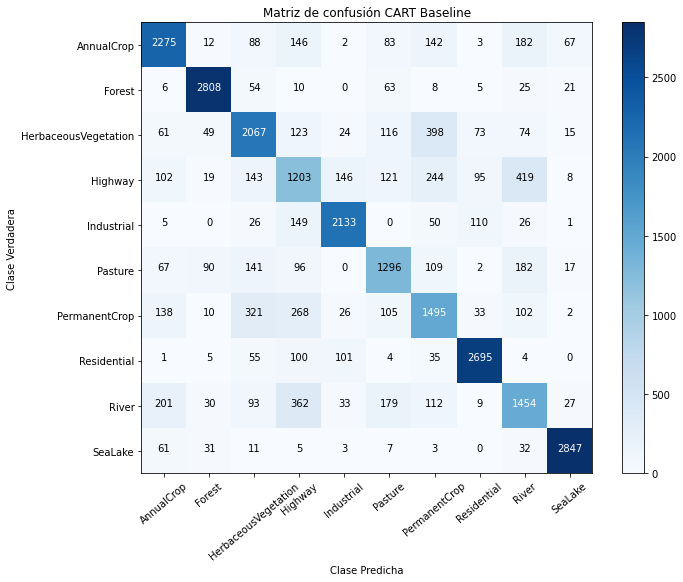

In [ ]:
y_pred = cross_val_predict(dectree, X, y, cv=2)

predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión CART Baseline'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

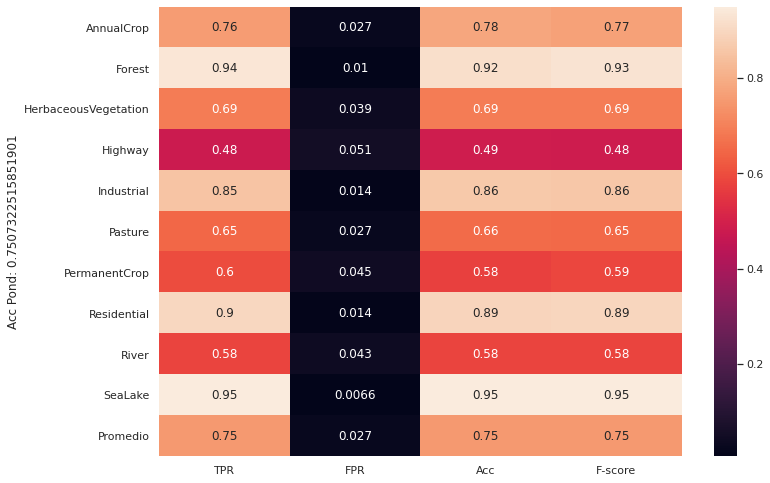

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

# 3. CART GLOBAL

In [ ]:
seed = 9 
dectree = DecisionTreeClassifier(random_state=seed)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [ ]:
score = cross_val_score(dectree, X_global, y, cv=kfold, scoring="accuracy")
print(score)

[0.81111111 0.79407407 0.80407407 0.80407407 0.80333333 0.80666667
 0.81962963 0.81074074 0.81814815 0.80740741]


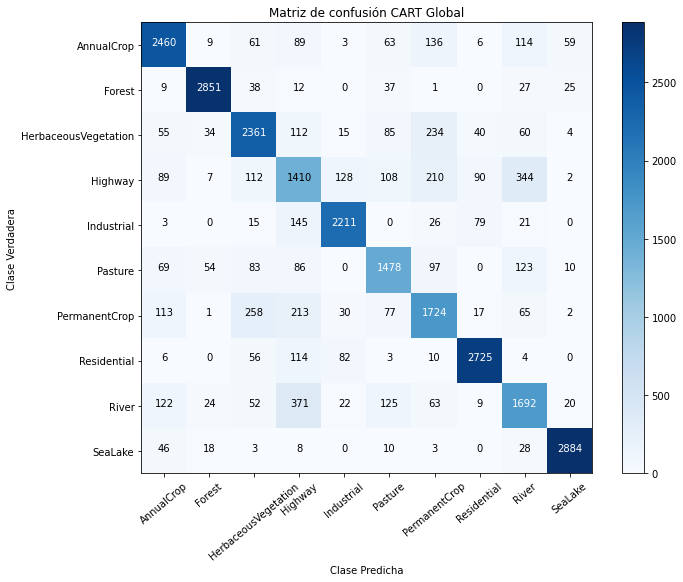

In [ ]:
y_pred = cross_val_predict(dectree, X_global, y, cv=10)

predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión CART Global'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

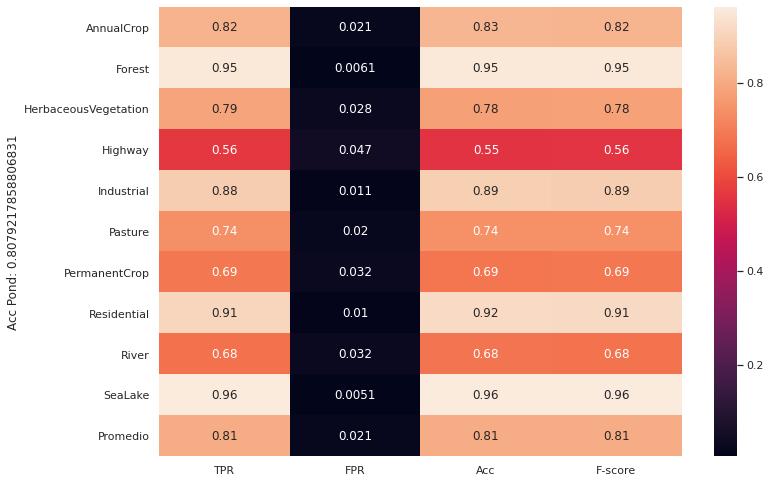

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

# 4. CART LOCAL

In [ ]:
seed = 9 
dectree = DecisionTreeClassifier(random_state=seed)
kfold = KFold(n_splits=2, random_state=seed, shuffle=True)

In [ ]:
score = cross_val_score(dectree, X_local, y, cv=kfold, scoring="accuracy")
print(score)

[0.33481481 0.33155556]


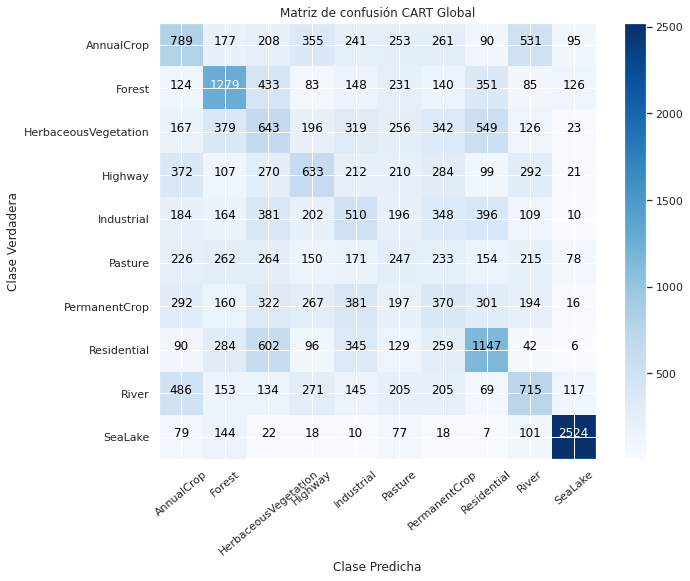

In [ ]:
y_pred = cross_val_predict(dectree, X_local, y, cv=2)

predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión CART Global'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

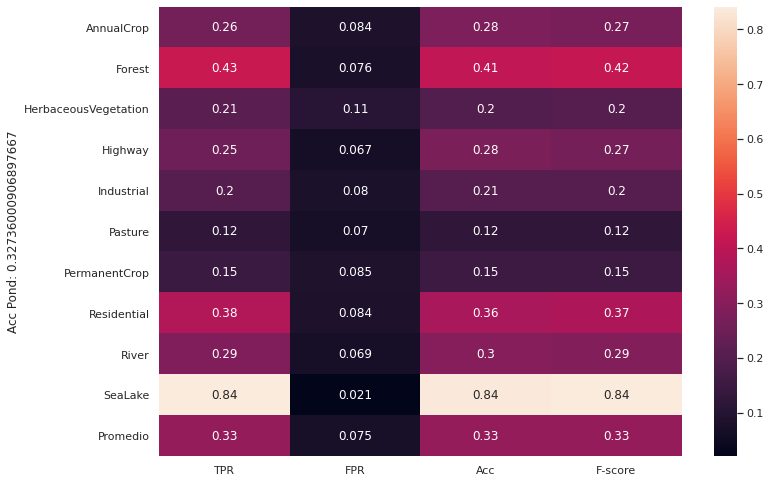

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

# 4. Feature Selection

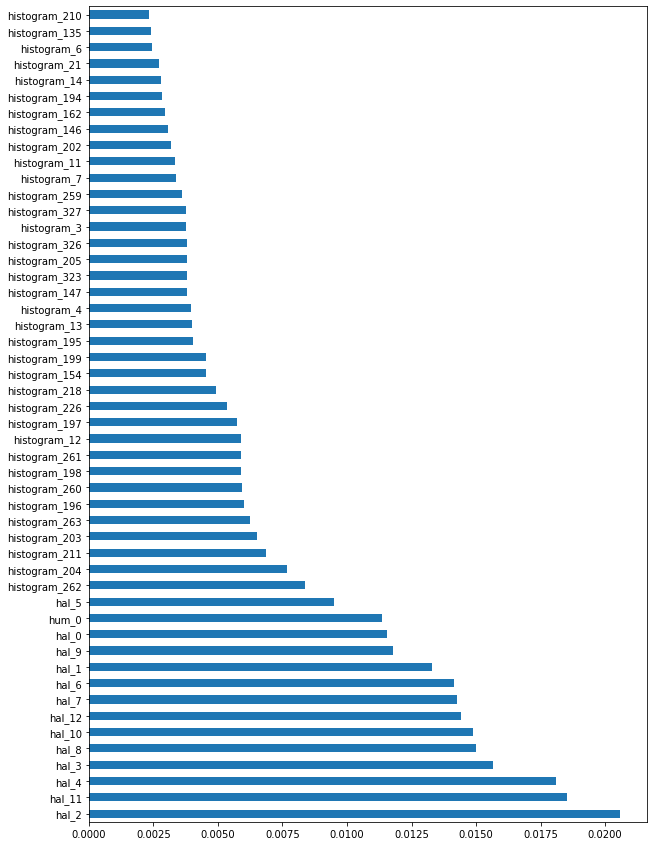

In [ ]:
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train,y_train)
feat_importances = pd.Series(rf_model.feature_importances_, index=X_x.columns)
# determinando los 400 atributos más importantes
df_imp_feat = feat_importances.nlargest(50)
# impresion de feats a .csv
df_imp_feat.to_csv('feature_selection_IMPORTANCE.csv')
# plot de 400 atributos
df_imp_feat.plot(kind='barh', figsize=(10,15))
plt.show()

In [ ]:
print(df_imp_feat[:50])

hal_2            0.020594
hal_11           0.018542
hal_4            0.018092
hal_3            0.015649
hal_8            0.014992
hal_10           0.014884
hal_12           0.014405
hal_7            0.014264
hal_6            0.014150
hal_1            0.013277
hal_9            0.011795
hal_0            0.011543
hum_0            0.011368
hal_5            0.009513
histogram_262    0.008382
histogram_204    0.007681
histogram_211    0.006864
histogram_203    0.006527
histogram_263    0.006241
histogram_196    0.006000
histogram_260    0.005922
histogram_198    0.005908
histogram_261    0.005890
histogram_12     0.005876
histogram_197    0.005738
histogram_226    0.005355
histogram_218    0.004920
histogram_154    0.004529
histogram_199    0.004528
histogram_195    0.004049
histogram_13     0.004003
histogram_4      0.003936
histogram_147    0.003810
histogram_323    0.003798
histogram_205    0.003796
histogram_326    0.003782
histogram_3      0.003770
histogram_327    0.003766
histogram_25

In [ ]:
type(df_imp_feat.index.values.tolist())

list

In [ ]:
fs_train = X_train_df[df_imp_feat.index.values.tolist()].copy()
fs_train.shape

(21600, 50)

In [ ]:
fs_test = X_test_df[df_imp_feat.index.values.tolist()].copy()
fs_test.shape

(5400, 50)

In [ ]:
fs_train = fs_train.values
fs_test = fs_test.values

In [ ]:
dectree = DecisionTreeClassifier(random_state=seed)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [ ]:
score = cross_val_score(dectree, fs_train, y_train, cv=kfold, scoring="accuracy")
print(score)

[0.79305556 0.80277778 0.79398148 0.78842593 0.80324074 0.79490741
 0.80231481 0.78287037 0.78842593 0.79675926]


In [ ]:
tfit = dectree.fit(fs_test, y_test)
dot_data = tree.export_graphviz(tfit, out_file=None, 
                     feature_names=df_imp_feat.index.values.tolist(),  
                     class_names=sorted(clases),  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("tree") 
graph

In [ ]:
y_pred = cross_val_predict(dectree, fs_test, y_test, cv=10)

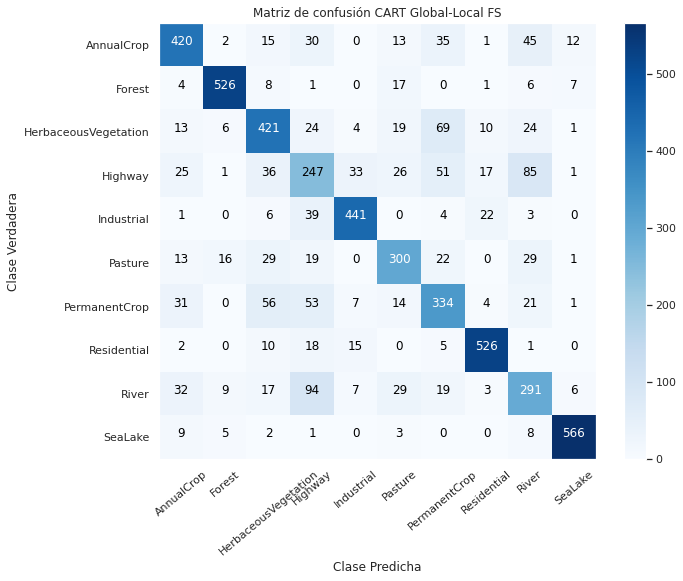

In [ ]:
predictions = np.float32(y_pred)
true_labels = np.float32(y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión CART Global-Local FS'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

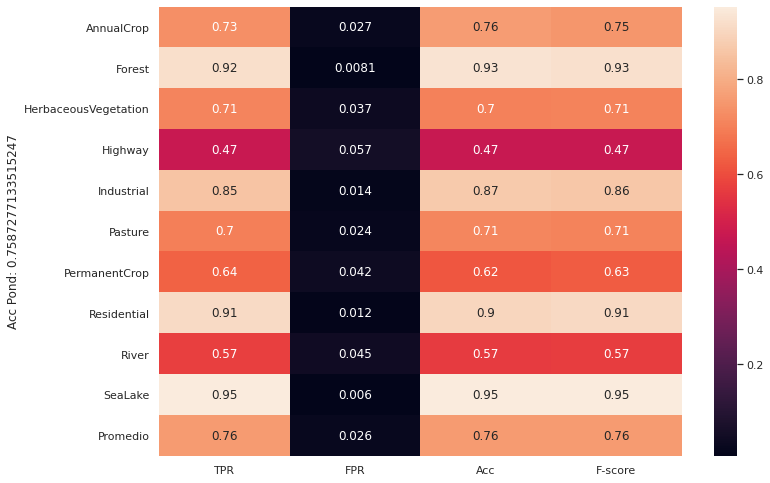

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

# 6. SVM FS

In [ ]:
svm = SVC(random_state=seed)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [ ]:
#X_global
score = cross_val_score(svm, fs_train, y_train, cv=kfold, scoring="accuracy")
print(score)

[0.52175926 0.54537037 0.52037037 0.52314815 0.49953704 0.51064815
 0.50925926 0.50648148 0.5375     0.50601852]


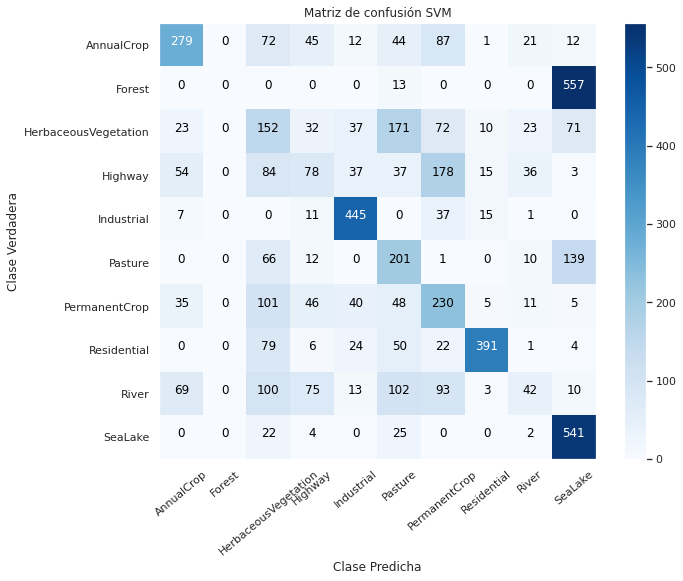

In [ ]:
y_pred = cross_val_predict(svm, fs_test, y_test, cv=10)
predictions = np.float32(y_pred)
true_labels = np.float32(y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión SVM'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


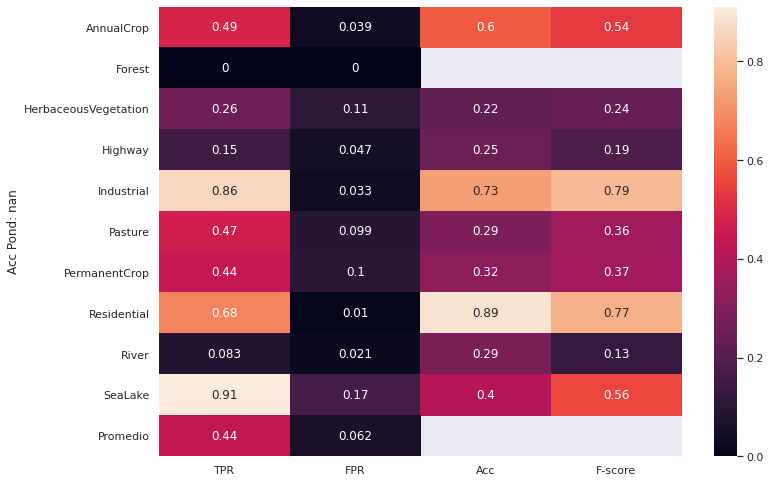

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

# 7. Bagging Cart

In [ ]:
Xclassifiers = []
Yscore = []
kfold = KFold(n_splits=10, shuffle=True)
cart =  DecisionTreeClassifier(random_state=seed)
for i in range(500):
  if i%100 == 0:
    rf = RandomForestClassifier(n_estimators=i+1, class_weight='balanced_subsample')#, random_state=seed, learning_rate=1.5)
    score = cross_val_score(rf, fs_train, y_train, cv=kfold, scoring="accuracy")
    Yscore.append(score)
    Xclassifiers.append(i+1)
    print("iter: %s, score: %s"%(i,np.mean(score)))


0.8758333333333334


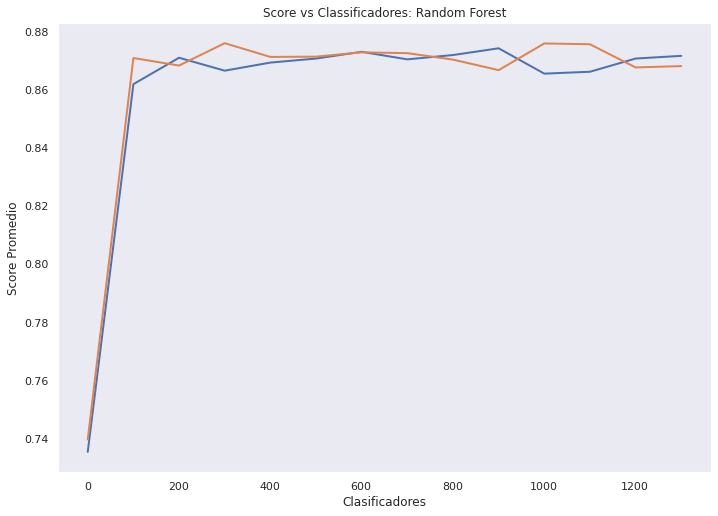

In [ ]:
plt.figure()
plt.plot(Xclassifiers, Yscore,lw=2)
plt.xlabel('Clasificadores')
plt.ylabel('Score Promedio')
plt.title('Score vs Classificadores: Random Forest')
print(np.max(Yscore))
plt.grid()
plt.show() 

In [ ]:
rf = RandomForestClassifier(n_estimators=300 , class_weight='balanced_subsample', random_state=seed, n_jobs=-1)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [ ]:
score = cross_val_score(rf, fs_train, y_train, cv=kfold, scoring="accuracy")
print(score)

[0.87777778 0.88842593 0.87962963 0.88425926 0.87777778 0.88009259
 0.88287037 0.88009259 0.88518519 0.88564815]


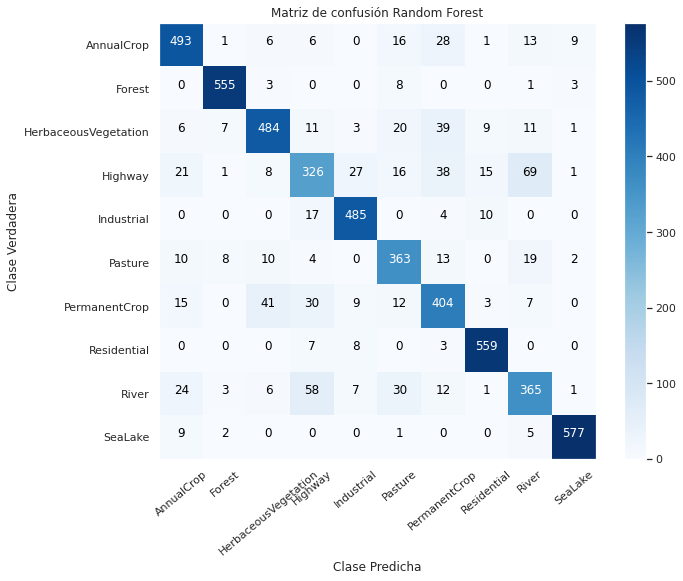

In [ ]:
y_pred = cross_val_predict(rf, fs_test, y_test, cv=10)

predictions = np.float32(y_pred)
true_labels = np.float32(y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión Random Forest'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

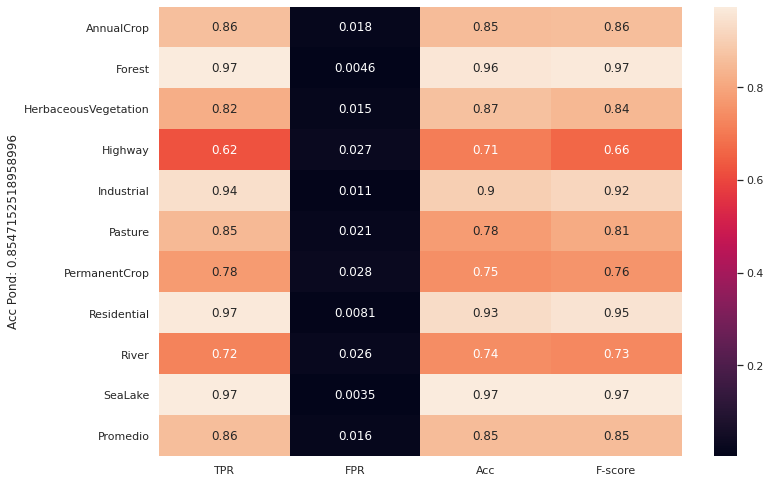

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

# 7. MLP

In [ ]:
%tensorflow_version 1.x
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
input_dim = (df_imp_feat.shape[0],)
print(input_dim)

(50,)


In [ ]:
def create_mlp(input_dim, n_clases):
  model = Sequential()
  model.add(Dense(64, input_shape=input_dim, activation='relu'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(BatchNormalization(epsilon=1e-06, momentum=0.9))
  model.add(Dropout(0.5)) 
  model.add(Dense(128, activation='relu'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(BatchNormalization(epsilon=1e-06, momentum=0.9))
  model.add(Dropout(0.5)) 
  model.add(Dense(128, activation='relu'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(BatchNormalization(epsilon=1e-06, momentum=0.9))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(BatchNormalization(epsilon=1e-06, momentum=0.9))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(BatchNormalization(epsilon=1e-06, momentum=0.9))
  model.add(Dropout(0.5))
  model.add(Dense(n_clases, activation='softmax'))
  return model

'''mlp = Sequential()
  mlp.add(Dense(128, input_shape=input_dim, activation='relu'))
  mlp.add(Dropout(0.2))
  mlp.add(Dense(128, input_shape=input_dim, activation='relu'))
  mlp.add(Dropout(0.2))
  mlp.add(Dense(128, input_shape=input_dim, activation='relu'))
  mlp.add(Dropout(0.2))
  mlp.add(Dense(n_clases, activation='softmax'))'''

#model = Sequential()
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(no_classes, activation='softmax'))


def load_mlp(input_dim, n_clases, weights_path):
   model = create_mlp(input_dim, n_clases)
   model.load_weights(weights_path)
   return model

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)

#skf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True) 

In [ ]:
ybin_train = to_categorical(y_train)
ybin_test = to_categorical(y_test)

In [ ]:
ybin_test.shape

(5400, 10)

In [ ]:
fold_no = 1
history = []
acc_per_fold = []
kfold = KFold(n_splits=10, shuffle=True)
for train, test in kfold.split(fs_train, ybin_train):
  mlp = create_mlp(input_dim, n_clases)

  # Compile the model
  mlp.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
  # checkpoint
  filepath="weights_%s.hdf5"%fold_no
  checkpoint = [ModelCheckpoint(filepath=os.path.join(path,filepath), 
                               monitor='val_loss', verbose=1, 
                               save_best_only=True, mode='min')]

  print(f'Entrenamiento por fold {fold_no} ...')

  history.append(mlp.fit(fs_train[train], ybin_train[train],
              batch_size=32,
              epochs=50,
              validation_data = (fs_train[test], ybin_train[test]),
              verbose=1,
              callbacks=checkpoint,
              shuffle=True))

  scores = mlp.evaluate(fs_test, ybin_test, verbose=0)
  print(f'Score por fold {fold_no}: {mlp.metrics_names[0]} de {scores[0]}; {mlp.metrics_names[1]} de {scores[1]*100}%')
  acc_per_fold.append(scores[1])
  #loss_per_fold.append(scores[0])
  fold_no = fold_no + 1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Entrenamiento por fold 1 ...
Train on 19440 samples, validate on 2160 samples
Epoch 1/50
19232/19440 [============================>.] - ETA: 0s - loss: 2.0809 - acc: 0.3070
Epoch 00001: val_loss improved from inf to 1.30944, saving model to /content/drive/MyDrive/EuroSat/EuroSAT/weights_1.hdf5
19440/19440 [==============================] - 8s 430us/sample - loss: 2.0746 - acc: 0.3089 - val_loss: 1.3094 - val_acc: 0.5361
Epoch 2/50
19328/19440 [============================>.] - ETA: 0s - loss: 1.4802 - acc: 0.4729
Epoch 00002: val_loss improved from 1.30944 to 1.09560, saving model to /content/drive/MyDrive/EuroSat/EuroSAT/weights_1.hdf5
19440/19440 [==============================] - 5s 281us/sample - loss: 1.4799 - acc: 0.4727 - val_loss: 1.0956 - val_acc: 0.6181
Epoch 3/50
19232/19440 [============================>.] - ETA: 0s - loss: 1.3544 - acc: 0.5247
Epoch 00003: val_loss improved from 1.09560 to 1.0

In [ ]:
np.mean(acc_per_fold)

0.7304259

In [ ]:
type(history[0].history['val_acc'])

list

In [ ]:
len(acc_per_fold)

10

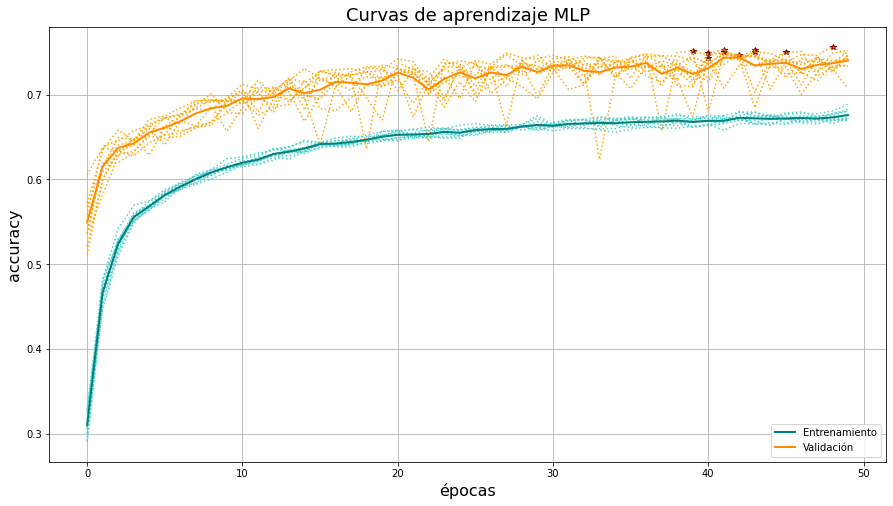

9


In [ ]:
def learning_curves(h,titulo):
    plt.figure(figsize=(15,8))
    acc = np.full((50,), np.nan)
    val_acc = np.full((50,), np.nan)
    max = np.NINF
    for i in range(10):
      epoch_max = np.argmax(h[i].history['val_acc'])
      if epoch_max > max:
        max = epoch_max
        modelo = i+1
      plt.plot(epoch_max, h[i].history['val_acc'][epoch_max],'*', color='maroon')
      plt.plot(h[i].history["acc"],color='mediumturquoise', linestyle=':')
      plt.plot(h[i].history["val_acc"],color='orange', linestyle=':')
      acc = np.vstack((acc, np.array(h[i].history["acc"])))
      val_acc = np.vstack((val_acc, np.array(h[i].history["val_acc"])))
    acc = np.delete(acc, 0, 0)
    val_acc = np.delete(val_acc, 0, 0)
    acc = np.mean(acc, axis=0)
    val_acc = np.mean(val_acc, axis=0)
    plt.plot(acc, label='Entrenamiento', color='teal', linewidth=2)
    plt.plot(val_acc, label='Validación', color='darkorange', linewidth=2)
    plt.legend(loc='lower right')
    plt.xlabel('épocas',fontsize=16)
    plt.ylabel('accuracy',fontsize=16)
    plt.title(titulo,fontsize=18)
    #plt.ylim(0.5,0.65)
    plt.grid(True)
    plt.show()
    return modelo
    
modelo = learning_curves(history,'Curvas de aprendizaje MLP')
print(modelo)

In [ ]:
model_path = "weights_%s.hdf5"%9
mlp_test = load_mlp(input_dim, n_clases, os.path.join(path,model_path))
mlp_test.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 64)                3264      
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 64)                256       
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)             

In [ ]:
  predicted_classes = mlp_test.predict(fs_test)
  predicted_class_indices=np.rint(predicted_classes)
  print(predicted_classes.shape)
  print(predicted_class_indices.shape)

(5400, 10)
(5400, 10)


(5400,)
(5400,)


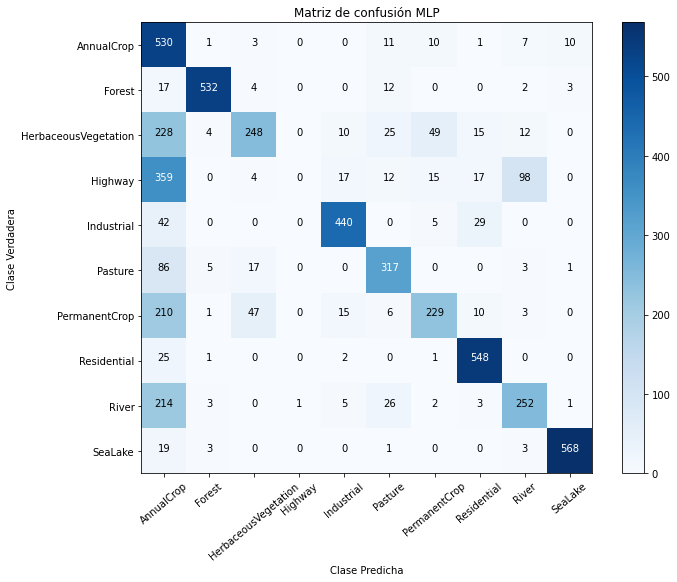

In [ ]:
predictions = np.asarray([k.dot(range(10)) for k in predicted_class_indices])
true_labels = np.asarray([k for k in y_test])
print(predictions.shape)
print(true_labels.shape)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(10))
tit = 'Matriz de confusión MLP'
plot_confusion_matrix(cnf_matrix, clases, tit, normalize=False)
#print(predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


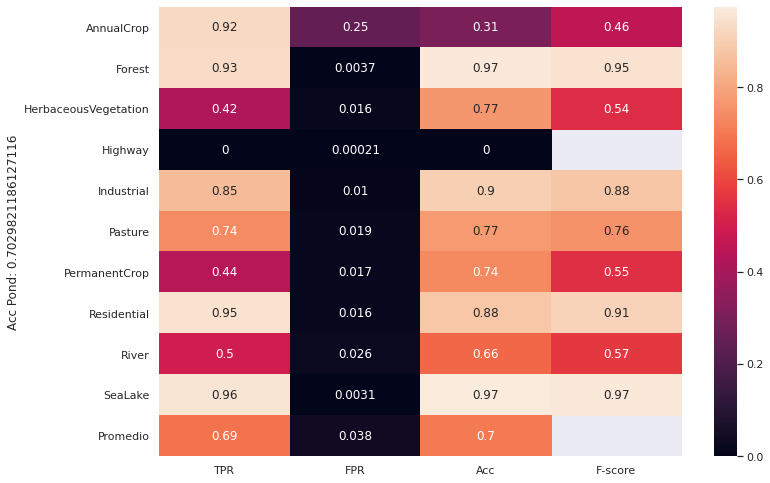

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)